Since it is mentioned in Supplementary of the Paper that the input was provided using the tf.example protocol buffer, thus we created the tfrec dataset for the same. This file contains the code from the visualising a certain image and then converting it to tfrec and eventually extracting the image from it and then sizing and normalizing it according the input requirements of the model. After that the query is performed on the google tflite model. 

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np 
import matplotlib.pyplot as plt
import json
from PIL import Image
import os

### Paths

In [2]:
MODEL_PATH = 'model path'
CURRENT_PATH = os.getcwd()
IMAGE_PATH = CURRENT_PATH + '/01845__00571.jpg'
JSON_PATH = CURRENT_PATH + '/01845__00571.json'
TFREC_PATH = CURRENT_PATH + '/temp.tfrec'

In [3]:
image_vis = Image.open(IMAGE_PATH)
meta_vis = json.load(open(JSON_PATH))

In [4]:
lx, ly, lw, lh = meta_vis['leye_x'], meta_vis['leye_y'], meta_vis['leye_w'], meta_vis['leye_h']
rx, ry, rw, rh = meta_vis['reye_x'], meta_vis['reye_y'], meta_vis['reye_w'], meta_vis['reye_h']

In [24]:
print('\nBounding Box Values for Left Eye - ',lx,ly,lw,lh)
print('\nBounding Box Values for Right Eye - ',rx,ry,rw,rh)


Bounding Box Values for Left Eye -  223 284 77 77

Bounding Box Values for Right Eye -  119 296 77 77


In [5]:
x_gt, y_gt = meta_vis['dot_xcam'], meta_vis['dot_y_cam']
print('\nGround Truth Values - ', x_gt, y_gt)


Ground Truth Values -  -1.93875 -5.5845


In [6]:
l_eye = image_vis.crop((max(0, lx), max(0, ly), max(0, lx+lw), max(0, ly+lh)))
r_eye = image_vis.crop((max(0, rx), max(0, ry), max(0, rx+rw), max(0, ry+rh)))

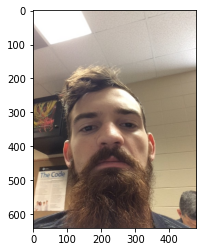

In [7]:
plt.imshow(image_vis)

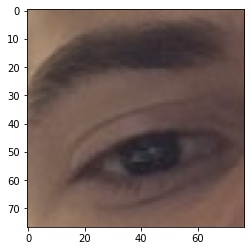

In [8]:
plt.imshow(r_eye)

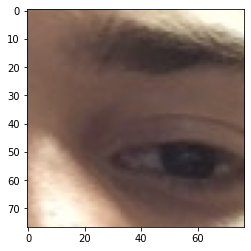

In [9]:
plt.imshow(l_eye)

In [10]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


In [11]:
def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "device": bytes_feature(example["device"]),
        "screen_h": int64_feature(example["screen_h"]),
        "screen_w": int64_feature(example["screen_w"]),
        "face_valid": int64_feature(example["face_valid"]),
        "face_x": int64_feature(example["face_x"]),
        "face_y": int64_feature(example["face_y"]),
        "face_w": int64_feature(example["face_w"]),
        "face_h": int64_feature(example["face_h"]),
        "leye_x": int64_feature(example["leye_x"]),
        "leye_y": int64_feature(example["leye_y"]),
        "leye_w": int64_feature(example["leye_w"]),
        "leye_h": int64_feature(example["leye_h"]),
        "reye_x": int64_feature(example["reye_x"]),
        "reye_y": int64_feature(example["reye_y"]),
        "reye_w": int64_feature(example["reye_w"]),
        "reye_h": int64_feature(example["reye_h"]),
        "dot_xcam": float_feature(example["dot_xcam"]),
        "dot_y_cam": float_feature(example["dot_y_cam"]),
        "dot_x_pix": float_feature(example["dot_x_pix"]),
        "dot_y_pix": float_feature(example["dot_y_pix"]),
        "reye_x1": int64_feature(example["reye_x1"]),
        "reye_y1": int64_feature(example["reye_y1"]),
        "reye_x2": int64_feature(example["reye_x2"]),
        "reye_y2": int64_feature(example["reye_y2"]),
        "leye_x1": int64_feature(example["leye_x1"]),
        "leye_y1": int64_feature(example["leye_y1"]),
        "leye_x2": int64_feature(example["leye_x2"]),
        "leye_y2": int64_feature(example["leye_y2"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


In [12]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "device": tf.io.FixedLenFeature([], tf.string),
        "screen_h": tf.io.FixedLenFeature([], tf.int64),
        "screen_w": tf.io.FixedLenFeature([], tf.int64),
        "face_valid": tf.io.FixedLenFeature([], tf.int64),
        "face_x": tf.io.FixedLenFeature([], tf.int64),
        "face_y": tf.io.FixedLenFeature([], tf.int64),
        "face_w": tf.io.FixedLenFeature([], tf.int64),
        "face_h": tf.io.FixedLenFeature([], tf.int64),
        "leye_x": tf.io.FixedLenFeature([], tf.int64),
        "leye_y": tf.io.FixedLenFeature([], tf.int64),
        "leye_w": tf.io.FixedLenFeature([], tf.int64),
        "leye_h": tf.io.FixedLenFeature([], tf.int64),
        "reye_x": tf.io.FixedLenFeature([], tf.int64),
        "reye_y": tf.io.FixedLenFeature([], tf.int64),
        "reye_w": tf.io.FixedLenFeature([], tf.int64),
        "reye_h": tf.io.FixedLenFeature([], tf.int64),
        "dot_xcam": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_cam": tf.io.FixedLenFeature([], tf.float32),
        "dot_x_pix": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_pix": tf.io.FixedLenFeature([], tf.float32),
        "reye_x1": tf.io.FixedLenFeature([], tf.int64),
        "reye_y1": tf.io.FixedLenFeature([], tf.int64),
        "reye_x2": tf.io.FixedLenFeature([], tf.int64),
        "reye_y2": tf.io.FixedLenFeature([], tf.int64),
        "leye_x1": tf.io.FixedLenFeature([], tf.int64),
        "leye_y1": tf.io.FixedLenFeature([], tf.int64),
        "leye_x2": tf.io.FixedLenFeature([], tf.int64),
        "leye_y2": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

In [25]:
with tf.io.TFRecordWriter(TFREC_PATH) as writer:
    image = tf.io.decode_jpeg(tf.io.read_file(IMAGE_PATH))
    json_file = json.load(open(JSON_PATH))
    example = create_example(image, IMAGE_PATH, json_file)
    writer.write(example.SerializeToString())

I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-21 15:49:28.356385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14640 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1c:00.0, compute capability: 7.0

device: b'iPhone 5S'
dot_x_pix: 40.0
dot_xcam: -1.9387500286102295
dot_y_cam: -5.584499835968018
dot_y_pix: 284.0
face_h: 258
face_valid: 1
face_w: 258
face_x: 106
face_y: 256
leye_h: 77
leye_w: 77
leye_x: 223
leye_x1: 253
leye_x2: 298
leye_y: 284
leye_y1: 340
leye_y2: 342
path: b'/lustre03/project/6061451/shared/script_to_google/01845__00571.jpg'
reye_h: 77
reye_w: 77
reye_x: 119
reye_x1: 143
reye_x2: 188
reye_y: 296
reye_y1: 353
reye_y2: 346
screen_h: 568
screen_w: 320
Image shape: (640, 480, 3)


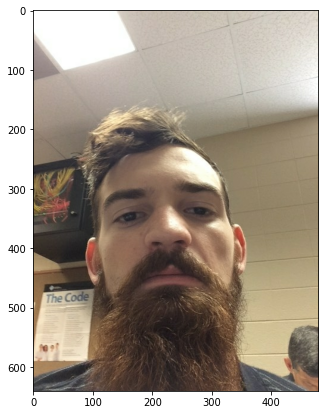

In [14]:
raw_dataset = tf.data.TFRecordDataset(TFREC_PATH)
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [15]:
raw_dataset = tf.data.TFRecordDataset(TFREC_PATH)
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    temp_img = features['image']
    temp_img_n = features['image'].numpy()
    image_vis = Image.fromarray(temp_img_n)
    
print('\nType tfrec direct - ',type(temp_img))
print('\nType - ',type(temp_img_n))
print('\nShapes - ',temp_img_n.shape)


Type tfrec direct -  <class 'tensorflow.python.framework.ops.EagerTensor'>

Type -  <class 'numpy.ndarray'>

Shapes -  (640, 480, 3)


In [16]:
l_eye = image_vis.crop((max(0, lx), max(0, ly), max(0, lx+lw), max(0, ly+lh)))
r_eye = image_vis.crop((max(0, rx), max(0, ry), max(0, rx+rw), max(0, ry+rh)))

l_eye = l_eye.transpose(Image.FLIP_LEFT_RIGHT)

/tmp/ipykernel_63706/3421407024.py:4: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  l_eye = l_eye.transpose(Image.FLIP_LEFT_RIGHT)


In [17]:
left_bb = np.array([[lx, ly, lw, lh]])
left_bb = tf.convert_to_tensor(left_bb,tf.float32) #left bounding box
right_bb = np.array([[rx, ry, rw, rh]])
right_bb = tf.convert_to_tensor(right_bb,tf.float32) #right bounding box 

# print('\nmean and std dev first channel left eye')
# print(np.mean(x_fin_a))
# print(np.std(x_fin_a))

In [18]:
r_eye = np.asarray(r_eye)
l_eye = np.asarray(l_eye)

#resizing to 128x128
r_eye = tf.convert_to_tensor(r_eye,tf.float32)
r_eye_resized = tf.image.resize(r_eye, [128,128])    
l_eye = tf.convert_to_tensor(l_eye,tf.float32)
l_eye_resized = tf.image.resize(l_eye, [128,128])

In [19]:
#normailizing the image channel wise
r_eye_res_np = np.asarray(r_eye_resized)
l_eye_res_np = np.asarray(l_eye_resized)    

In [20]:
#right eye image normalization
mean_one = np.mean(r_eye_res_np[:,:,0])
mean_two = np.mean(r_eye_res_np[:,:,1])
mean_three = np.mean(r_eye_res_np[:,:,2])

std_one = np.std(r_eye_res_np[:,:,0])
std_two = np.std(r_eye_res_np[:,:,1])
std_three = np.std(r_eye_res_np[:,:,2])    

x_a = r_eye_res_np[:,:,0] - mean_one
x_b = r_eye_res_np[:,:,1] - mean_two
x_c = r_eye_res_np[:,:,2] - mean_three    

x_fin_a = x_a/std_one
x_fin_b = x_b/std_two
x_fin_c = x_c/std_three

r_eye_final_np = np.stack((x_fin_a,x_fin_b,x_fin_c),axis=2) #final numpy array of right eye after resizing and normalization

In [21]:
#left eye image normalization
mean_one = np.mean(l_eye_res_np[:,:,0])
mean_two = np.mean(l_eye_res_np[:,:,1])
mean_three = np.mean(l_eye_res_np[:,:,2])

std_one = np.std(l_eye_res_np[:,:,0])
std_two = np.std(l_eye_res_np[:,:,1])
std_three = np.std(l_eye_res_np[:,:,2])    

x_a = l_eye_res_np[:,:,0] - mean_one
x_b = l_eye_res_np[:,:,1] - mean_two
x_c = l_eye_res_np[:,:,2] - mean_three    

x_fin_a = x_a/std_one
x_fin_b = x_b/std_two
x_fin_c = x_c/std_three

l_eye_final_np = np.stack((x_fin_a,x_fin_b,x_fin_c),axis=2) #final numpy array of left eye after resizing and normalization

In [22]:
r_eye_t = tf.convert_to_tensor(r_eye_final_np,tf.float32)
l_eye_t = tf.convert_to_tensor(l_eye_final_np,tf.float32)  

l_eye_final = tf.expand_dims(l_eye_t, 0) #final left eye as tensor - [1,128,128,3]  
r_eye_final = tf.expand_dims(r_eye_t, 0)  #final right eye as tensor - [1,128,128,3] 

### Input Types and Shapes

In [23]:
print('\nEye Shapes -')
print(l_eye_final.shape)
print(r_eye_final.shape)

print('\nCropped Eye Data Types -')
print(type(r_eye_final))
print(type(l_eye_final))

print('\nBounding Box Coordinates Shape-')
print(right_bb.shape)
print(left_bb.shape)

print('\nBounding Box Data Types-')
print(type(right_bb))
print(type(left_bb))


Eye Shapes -
(1, 128, 128, 3)
(1, 128, 128, 3)

Cropped Eye Data Types -
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>

Bounding Box Coordinates Shape-
(1, 4)
(1, 4)

Bounding Box Data Types-
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
interpreter = tf.lite.Interpreter(MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

### Model Input Details

In [ ]:
print('\nInput Details')
print(input_details)

Input Details
[{'name': 'serving_default_eye/right/bounding_box_norm:0', 'index': 0, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_eye/left/bounding_box_norm:0', 'index': 1, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_eye/image/right/color/128x128:0', 'index': 2, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_eye/image/left_flip/color/128x128:0', 'index': 3, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


### Model Output Details

In [ ]:
print('\nOutput Details')
print(output_details)

Output Details
[{'name': 'StatefulPartitionedCall:0', 'index': 41, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
interpreter.set_tensor(input_details[0]['index'], right_bb)
interpreter.set_tensor(input_details[1]['index'], left_bb)
interpreter.set_tensor(input_details[2]['index'], r_eye_final)
interpreter.set_tensor(input_details[3]['index'], l_eye_final)
interpreter.invoke()

In [ ]:
output_data = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print('\nOutput -')
print(output_data)

print('\nOutput Data Type-')
print(type(output_data))

print('\nOutput Shape -')
print(output_data.shape)

Output -
[[  0.        203.7475      0.          2.1516268]]

Output Data Type-
<class 'numpy.ndarray'>

Output Shape -
(1, 4)